In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [3]:
model_dir = "../models/v7_detseparated/"
model_name = "v7_detseparated"
model_version = 1
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi","seed_swissCross","seed_nxtals",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi","cl_swissCross", "cl_nxtals"]
os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [8]:
files_ele = "/storage/ECAL/training_data/electrons/numpy_v9/training/"
files_gamma = "/storage/ECAL/training_data/gammas/numpy_v9/training/"

In [4]:
files_ele = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v9/training/"
files_gamma = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v9/training/"

In [9]:
datas_ele = []

for f in glob.glob(files_ele+"*.pkl"):
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
for f in glob.glob(files_gamma+"*.pkl"):
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  15041642
N events gamma:  14660468


Balance gamma and electron

In [10]:
data_EB = data[abs(data.seed_eta)<1.479]
data_EE = data[abs(data.seed_eta)>=1.479]

In [11]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 16001279
Sample in EE: 13319657
Sample in EB in SC: 817964
Sample in EE in SC: 454311
N in supercluster:  1272275
N out supercluster:  28048661
22.046067870546857


In [12]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  20712992
Not caloMatch samples:  8607944


## Check plots

In [9]:
data_in = data[ (data.is_seed == False) & data.in_scluster]
data_out =  data[(data.is_seed == False) & (data.in_scluster == False)]

## Weights by DeltaPhi

In [45]:
data = data_EE

In [46]:
inSC = len(data[(data.is_seed == False) & (data.in_scluster == True)])
data = pd.concat([data[(data.is_seed == False) & (data.in_scluster == True)],
                  data[(data.is_seed == False) & (data.in_scluster == False)].iloc[:25*inSC]])

In [46]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)
data["w"] = data.in_scluster.apply(lambda a: w if a else 1.)
weight = data.w.values

28.318367814118524


In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_EB.pkl".format(model_version), "wb"))

In [47]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir+"/scaler_model_v{}_EE.pkl".format(model_version), "wb"))

In [68]:
scaler.mean_

array([-9.48937722e-02, -2.59092069e-02, -3.23802034e-02,  8.54387012e+01,
        1.95493967e+01, -7.99008024e-03,  1.68780274e-05,  8.92748605e+00,
        1.92283524e+00,  1.08804190e+00,  3.39450646e-02,  1.85485538e-05,
        4.13554904e-02,  4.96716655e-01,  5.44590774e+00,  4.09401210e+00,
        3.71462585e-02,  4.80538918e-05,  4.39461957e-02,  5.70297494e-01,
        3.15806715e+00])

In [69]:
scaler.scale_

array([2.27502784e+00, 1.80358311e+00, 9.99475624e-01, 1.25874656e+02,
       2.62122915e+01, 1.01794340e-01, 1.81101293e-01, 6.05398279e+00,
       1.77231292e+00, 5.03589571e-01, 1.40048073e-02, 4.14562658e-04,
       1.53689902e-02, 4.13270103e-01, 5.68762983e+00, 9.93354108e+00,
       1.65018741e-02, 5.45041026e-04, 1.80243836e-02, 4.37347302e-01,
       4.28826919e+00])

In [48]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weight, test_size=0.30)

### Some plots

(array([3375875., 3435045.,  837322.,  337938.,  211172.,  171884.,
         151552.,  143535.,  137063.,  134114.,  129157.,  127777.,
         128256.,  126263.,  123992.,  121177.,  121275.,  123512.,
         122474.,  121534.,  121260.,  120654.,  120437.,  120935.,
         119281.,  119229.,  118079.,  117625.,  118254.,  119602.,
         117317.,  116562.,  118072.,  117502.,  117118.,  114995.,
         113437.,  114738.,  114147.,  112631.,  110049.,  108720.,
         104224.,  102127.,   93109.,   84271.,   70365.,   52575.,
          33402.,   17103.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  92.,  94.,  96.,  98., 100.]),
 <a list of 50 Patch objects>)

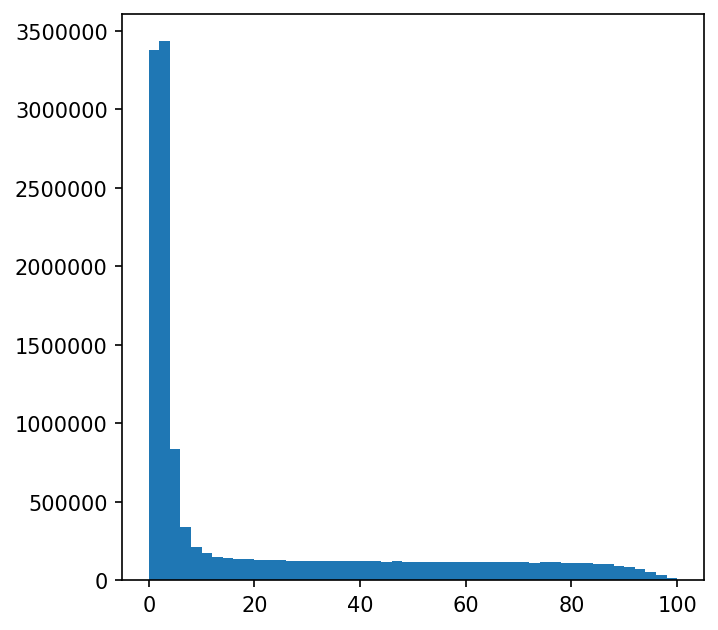

In [33]:
plt.hist(data.et_seed, bins=50, range=(0,100))

### Balancing the et regions

In [40]:
small_et = data[data.et_seed < 20].w.sum()
big_et = data[data.et_seed > 20].w.sum()

In [41]:
print(small_et)
print(big_et)

13451499.383351944
12279192.61664807


# Training

In [19]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

In [23]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               2200      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

In [49]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(200, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.01))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 200)               4400      
_________________________________________________________________
dropout_19 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)              

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 0.4
    drop = 0.65
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.002: return 0.002
    return lrate

In [25]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_EB.hd5".format(model_version), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 9600767 samples, validate on 6400512 samples
Epoch 1/400
9600767/9600767 [==============================] - 51s 5us/step - loss: 0.2299 - accuracy: 0.9627 - val_loss: 0.1581 - val_accuracy: 0.9697
Epoch 2/400
9600767/9600767 [==============================] - 51s 5us/step - loss: 0.1552 - accuracy: 0.9692 - val_loss: 0.1485 - val_accuracy: 0.9634

Epoch 00002: val_loss improved from inf to 0.14846, saving model to ../models/v7_detseparated//model_v1_EB.hd5
Epoch 3/400
9600767/9600767 [==============================] - 50s 5us/step - loss: 0.1481 - accuracy: 0.9698 - val_loss: 0.1425 - val_accuracy: 0.9774
Epoch 4/400
9600767/9600767 [==============================] - 50s 5us/step - loss: 0.1441 - accuracy: 0.9704 - val_loss: 0.1357 - val_accuracy: 0.9695

Epoch 00004: val_loss improved from 0.14846 to 0.13568, saving model to ../models/v7_detseparated//model_v1_EB.hd5
Epoch 5/400
9600767/9600767 [==============================] - 51s 5us/step - loss: 0.1418 - accuracy: 0.9705 

Epoch 44/400
9600767/9600767 [==============================] - 50s 5us/step - loss: 0.1268 - accuracy: 0.9721 - val_loss: 0.1225 - val_accuracy: 0.9738

Epoch 00044: val_loss improved from 0.12300 to 0.12254, saving model to ../models/v7_detseparated//model_v1_EB.hd5
Epoch 45/400
9600767/9600767 [==============================] - 50s 5us/step - loss: 0.1266 - accuracy: 0.9721 - val_loss: 0.1228 - val_accuracy: 0.9740
Epoch 46/400
9600767/9600767 [==============================] - 50s 5us/step - loss: 0.1266 - accuracy: 0.9722 - val_loss: 0.1229 - val_accuracy: 0.9714

Epoch 00046: val_loss did not improve from 0.12254
Epoch 47/400
9600767/9600767 [==============================] - 51s 5us/step - loss: 0.1264 - accuracy: 0.9722 - val_loss: 0.1220 - val_accuracy: 0.9728
Epoch 48/400
9600767/9600767 [==============================] - 51s 5us/step - loss: 0.1264 - accuracy: 0.9723 - val_loss: 0.1225 - val_accuracy: 0.9722

Epoch 00048: val_loss improved from 0.12254 to 0.12246, saving mod

In [50]:
auto_save = ModelCheckpoint(model_dir+ "/model_{}_EE.hd5".format(model_version) , monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=3)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save, ] #lr_scheduler
            )

Train on 9323759 samples, validate on 3995898 samples
Epoch 1/400
9323759/9323759 [==============================] - 45s 5us/step - loss: 0.2955 - accuracy: 0.9560 - val_loss: 0.2166 - val_accuracy: 0.9659
Epoch 2/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.2095 - accuracy: 0.9629 - val_loss: 0.1975 - val_accuracy: 0.9709
Epoch 3/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.2000 - accuracy: 0.9636 - val_loss: 0.1922 - val_accuracy: 0.9671

Epoch 00003: val_loss improved from inf to 0.19218, saving model to ../models/v7_detseparated//model_1_EE.hd5
Epoch 4/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1954 - accuracy: 0.9639 - val_loss: 0.1994 - val_accuracy: 0.9504
Epoch 5/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1920 - accuracy: 0.9641 - val_loss: 0.1914 - val_accuracy: 0.9743
Epoch 6/400
9323759/9323759 [==============================] - 44s 5us/step


Epoch 00045: val_loss did not improve from 0.16799
Epoch 46/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1715 - accuracy: 0.9666 - val_loss: 0.1667 - val_accuracy: 0.9700
Epoch 47/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1716 - accuracy: 0.9665 - val_loss: 0.1714 - val_accuracy: 0.9737
Epoch 48/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1710 - accuracy: 0.9666 - val_loss: 0.1669 - val_accuracy: 0.9664

Epoch 00048: val_loss improved from 0.16799 to 0.16693, saving model to ../models/v7_detseparated//model_1_EE.hd5
Epoch 49/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1713 - accuracy: 0.9664 - val_loss: 0.1659 - val_accuracy: 0.9670
Epoch 50/400
9323759/9323759 [==============================] - 44s 5us/step - loss: 0.1709 - accuracy: 0.9666 - val_loss: 0.1666 - val_accuracy: 0.9648
Epoch 51/400
9323759/9323759 [==============================] - 44s 

>>> Computing AUC...
AUC score: 0.9974846786955595
>>> Saving ROC curve...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


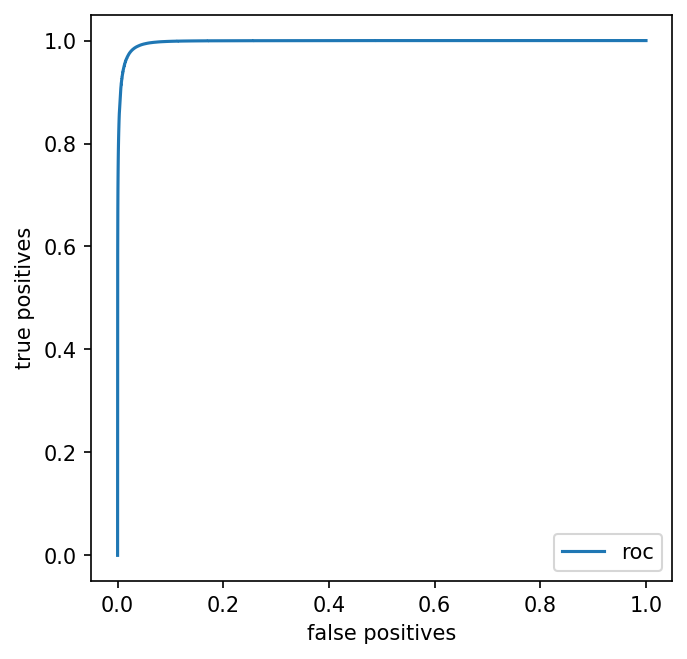

In [26]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

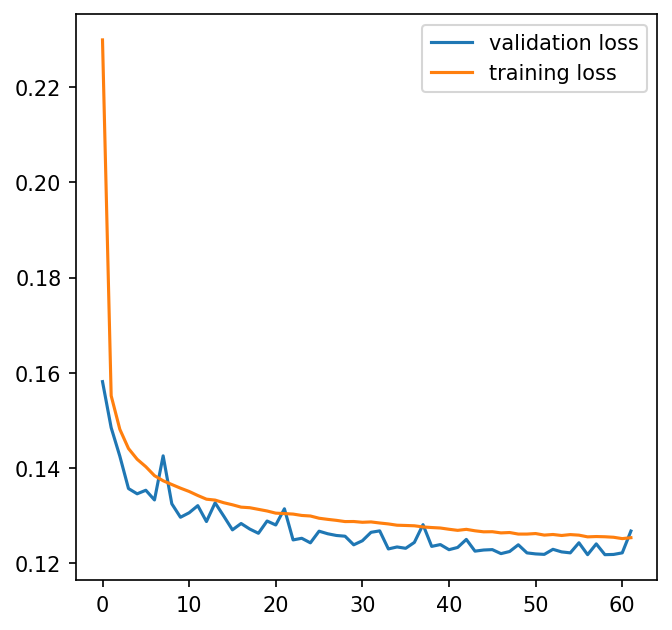

In [27]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

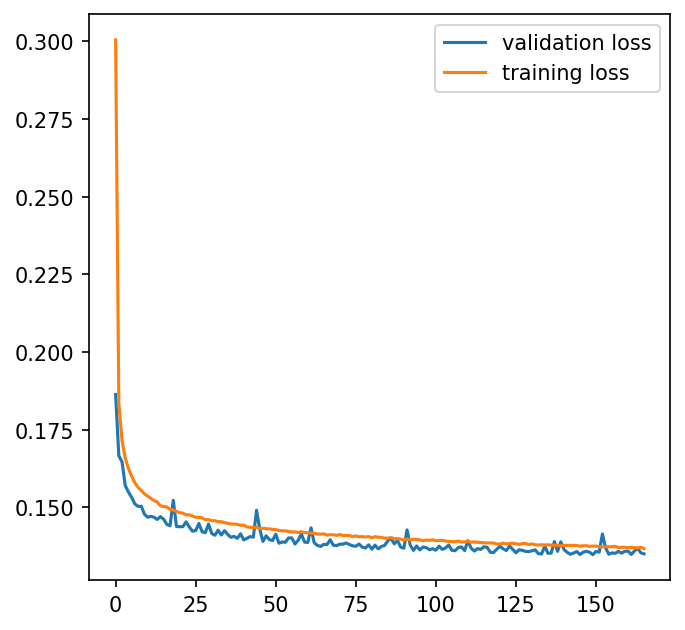

In [64]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

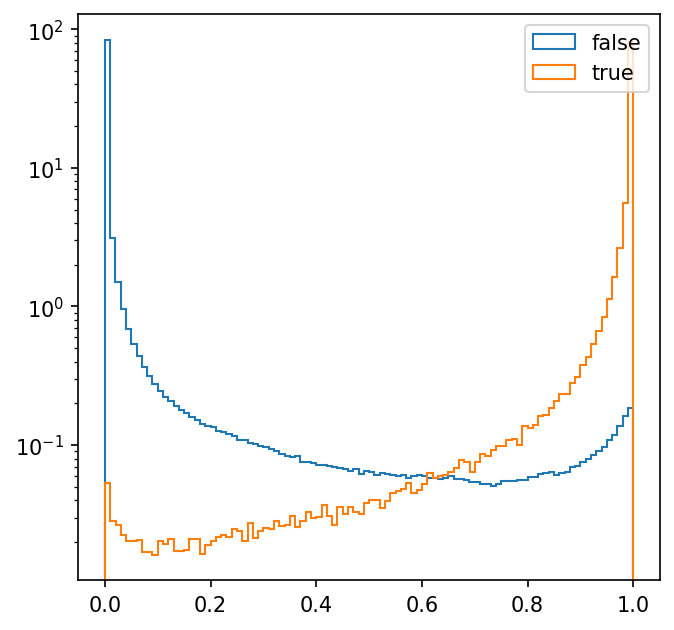

In [28]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

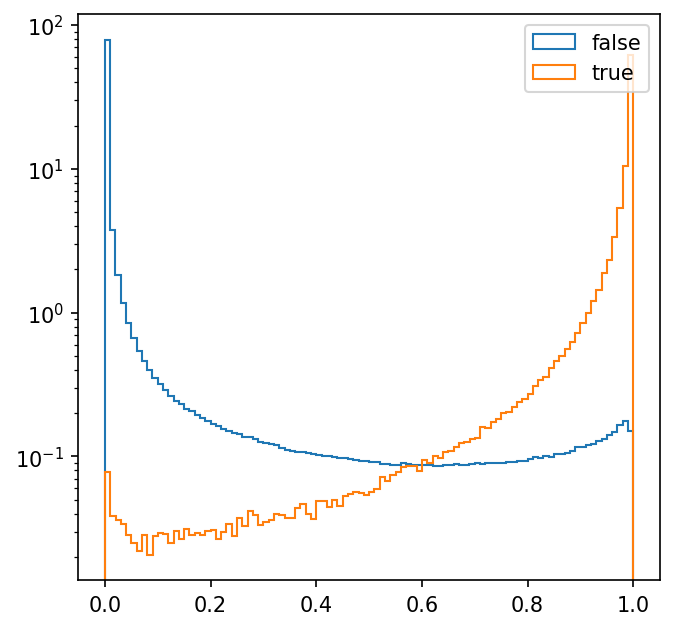

In [42]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [34]:
plt.savefig(model_dir +"/output_model_v1_EB.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

NameError: name 'y_test' is not defined

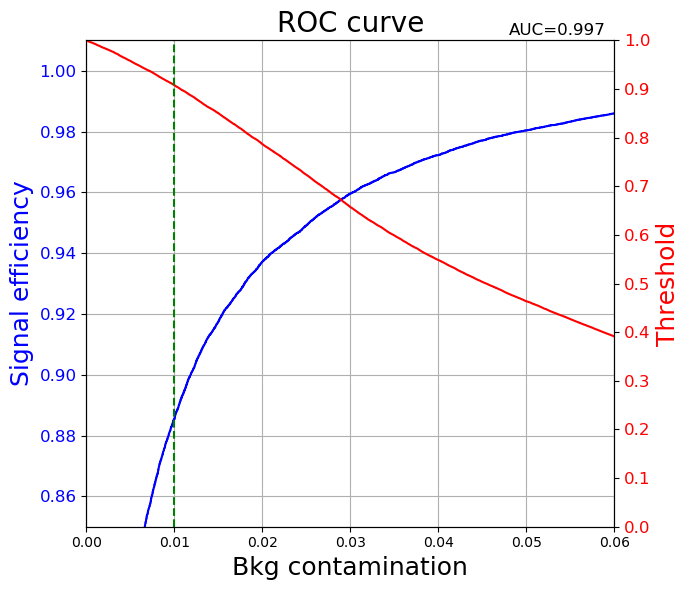

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()